In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import model_crommelin_seasonal
import feature_template
import feature_crommelin
from importlib import reload
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle
import tpt_utils
from sklearn.cluster import KMeans, MiniBatchKMeans
from datetime import datetime

In [3]:
import matplotlib.pyplot as plt 
%matplotlib inline

A sequence of flags specifies which cells to run.

In [12]:
create_reanalysis_flag =               0
create_hindcasts_flag =                0 
featurize_flag =                       1
recombine_features_flag =              1
compute_empirical_committor_flag =     1
cluster_flag =                         1
estimate_transmat_flag =               1

Create directories to save results 

In [13]:
# Organize the directory of data and features to be read from the data. 
topic_dir = "/scratch/jf4241/crommelin"
filedict = dict({
    "data": dict({
        "ra": dict({
            "traj": dict({
                "dir": join(topic_dir, "reanalysis", "trajectory", "2022-07-28", "0"), # Directory with possibly many files
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "reanalysis", "features_all", "2022-07-28", "0"),
                "filename": "crom_feat_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "reanalysis", "features_tpt", "2022-07-28", "0",),
                "filename": "crom_feat_tpt.nc",
            }),
        }),
        "hc": dict({
            "traj": dict({
                "dir": join(topic_dir, "hindcast", "trajectory", "2022-07-28", "0"), # Directory with possibly multiple files
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "hindcast", "features_all", "2022-07-28", "0"),
                "filename": "crom_feat_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "hindcast", "features_tpt", "2022-07-28", "0"),
                "filename": "crom_feat_tpt.nc",
            })
        }),        
    }),
    "results": dict({
        "dir": join(topic_dir, "results", "2022-07-28", "0")
    })
})

In [14]:
# Create the directories if they don't exist already
for src in ["ra","hc"]:
    for fmt in ["traj","feat_all","feat_tpt"]:
        path = filedict["data"][src][fmt]["dir"]
        if not exists(path):
            makedirs(path, exist_ok=True)
path = filedict["results"]["dir"]
if not exists(path): makedirs(path, exist_ok=True)

# Generating data

### 1. Model specification

Set physical parameters for the dynamical model, including the size of the channel, the strength of drag and forcing and dissipation, and the length of the annual cycle. All this is stored in a "fundamental parameter dictionary" (FPD)

In [15]:
fpd = dict({
    "b": 0.5, "beta": 1.25, "gamma_limits": [0.15, 0.22], 
    "C": 0.1, "x1star": 0.95, "r": -0.801, "year_length": 400.0,
})
crom = model_crommelin_seasonal.SeasonalCrommelinModel(fpd)

### 2. Reanalysis

Set simulation parameters for the reanalysis (RA) simulation. We will start the simulation partway through year 1957 (remember, the years are 400 days long, so this doesn't correspond to our world) and save out every 0.5 days. We will start with a 500-day "burn-in" period to let the system settle onto its attractor. 

In [16]:
dt_samp = 0.5 # Time step to save out
duration_burnin = 500.0 # Run 500 days of burn-in
t_init_burnin = (1957 + 0.2)*fpd["year_length"] # Start the burnin partway through 1957, in our pretend model world
duration_ra = 200.0*fpd["year_length"] # Run 200 years of reanalysis (abbreviated RA)

The model integration will be stored as a 3-dimensional array with shape `(Nx, Nt, xdim)`, where
* `Nx` is the number of parallel ensemble members. 
* `Nt` is the number of timesteps.
* `xdim` is the number of dimensions, or degrees of freedom, in the model. Here `xdim = 7` for `x_1,...,x_6,t`. 

I have added time-dependence to the model of Crommelin (2004) to make an explicitly seasonal event. For reanalysis, there is only one thread of history, so `Nx = 1`. Later, we will make hindcast data and have `Nx = 10`. We will initialize the integration with an array of shape `(Nx,xdim)` for the integrator. The integrator will automatically save out to a Netcdf file (`burnin.nc`), which will be opened afterward to initialize the long integration.

In [17]:
x0 = np.zeros((1,7))
x0[0,-1] = t_init_burnin # Time is the last dimension
t_save = np.arange(0, duration_burnin, dt_samp)
traj_filename_burnin = join(filedict["data"]["ra"]["traj"]["dir"], "burnin.nc")
crom.integrate_and_save(x0,t_save,traj_filename_burnin)

Now that we have let the model find its attractor, we set up a longer simulation starting from the end of the burn-in. Below we specify the filenames to save both the model integration and the model parameters.

In [18]:
x_burnin = xr.open_dataset(traj_filename_burnin)["X"]
x0 = x_burnin[:,-1].data # End of burn-in = beginning of reanalyis
t_init_str,_ = crom.date_format(x0[0,-1])
t_fin_str,_ = crom.date_format(x0[0,-1] + duration_ra)
traj_filename_ra = join(filedict["data"]["ra"]["traj"]["dir"], f"ra_{t_init_str}_to_{t_fin_str}.nc")
param_filename_ra = join(filedict["data"]["ra"]["traj"]["dir"], "params")

Below, we finally create the reanalysis data. Hopefully we don't need to do this too many times, so a flag is there to prevent running this cell every time. 

In [19]:
if create_reanalysis_flag:
    t_save = np.arange(0,duration,dt_samp)
    crom.integrate_and_save(x0,t_save,traj_filename_ra,metadata_filename=param_filename_ra)

### 3. Hindcasts

Now that we have reanalysis, we can make "hindcast" data by launching many perturbed parallel trajectories from reanalysis, to see alternative realities play out. The following parameters specify exactly which data to create:

* `t_range_hc` says what time window the hindcasts will cover, in this case 1960-1970 (a strict subset of the reanalysis period)
* `ens_size` is the size of each ensemble, in this case 10 (to match the S2S dataset).
* `ens_gap` is the time separation between subsequent ensembles, in this case 13 days. (For S2S, it's 2 or 3 days).
* `ens_duration` is the duration of the ensemble members, in this case 47 (to match the S2S dataset). 
* `pert_scale` is the size of random initial-condition perturbations. We choose `0.01` arbitrarily.

In [20]:
if create_hindcasts_flag:
    t_range_hc = crom.q["year_length"]*np.array([1960,1970])
    crom.generate_hindcast_dataset(
        [traj_filename_ra],filedict["data"]["hc"]["traj"]["dir"],t_range_hc,dt_samp,
        ens_size=10,ens_duration=47,ens_gap=13,pert_scale=0.01
    )

# Analyzing data

The first step of any data analysis routine is to extract features, or observables, of interest, which depend on the system at hand. The file `feature_template.py` defines an abstract class, `SeasonalFeatures`, for organizing features of a seasonal phenomenon into `xarray` datasets for easy access. (By "seasonal phenomenon", I mean some dynamics with a particular season of interest, e.g., winter.) The file `feature_crommelin.py` defines a subclass,  `SeasonalCrommelinModelFeatures`, which implements observables that are physically relevant to the simple blocking model. As the model is only `6+1`-dimensional, the feature space is actually larger than the model state space. For more realistic models, such as the ECMWF Integrated Forecast System (IFS) which produces hindcasts, the feature space will be a major *reduction* from the state space. The code below will specify which observables we want, as we read them.

In general, reading features from the dataset will be expensive, as we have to comb through a large database of files, so we should minimize the number of times we do this in development. One strategy is to separate the featurization into multiple stages, with each stage repeated less often than the previous one. 

### Stage 1: read all possible features of interest
The first stage is to read *all* possible features we *might* use for the downstream tasks and save them to a file, with the understanding that we will take some further reductions downstream. The list of observables for now is
* `identity`: the model state space
* `energy`: the energy contained in each wavenumber, as well as the total
* `energy_tendency`: the rate of change of total energy, and its decomposition into dissipation and forcing
* `energy_exchange`: the rate of energy *flow* between different wavenumbers, as well as dissipation and forcing, separated by wavenumber.
* `phase`: the phase of each wave (i.e., how it's shifted with respect to the zonal domain walls)

In [21]:
reload(feature_crommelin); reload(feature_template)

<module 'feature_template' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/crommelin/../../feature_template.py'>

In [22]:
crom_feat = feature_crommelin.SeasonalCrommelinModelFeatures()
qra = pickle.load(open(param_filename_ra,"rb")) # qra contains parameters of the Crommelin model

In [23]:
if featurize_flag:
    feat_all = dict()
    for src in ["ra","hc"]:
        ds_feature_list = []
        file_list = [f for f in os.listdir(filedict["data"][src]["traj"]["dir"]) if (f.startswith(src) and f.endswith(".nc"))]
        for filename in file_list:
            ds = xr.open_dataset(join(filedict["data"][src]["traj"]["dir"], filename))
            ds_feature_list += [
                xr.Dataset(
                    data_vars = dict({
                        # WARNING! So that this steps work, the 'feature' coordinate of each observable must be uniquely named. 
                        # For example, if the identity observable and energy observable both have a coordinate called "feature", 
                        # then xarray will assume it's the same and smush them together, filling in NaNs. This restricts what 
                        # we can use as feature names. 
                        "identity": crom_feat.identity_observable(ds, qra),
                        "energy": crom_feat.energy_observable(ds, qra),
                        "energy_tendency": crom_feat.energy_tendency_observable(ds, qra),
                        "energy_exchange": crom_feat.energy_exchange_observable(ds, qra),
                        "phase": crom_feat.phase_observable(ds, qra),
                    })
                )
            ]
            ds.close()
        feat_all[src] = xr.concat(ds_feature_list,dim="ensemble") # ensemble is a new dimension
        feat_all[src].to_netcdf(join(filedict["data"][src]["feat_all"]["dir"], filedict["data"][src]["feat_all"]["filename"]))

### Stage 2: Subset and recombine observables for use in TPT analysis
Provided we have pulled enough data from the raw files above, we can further subset those to a feature space we think is truly relevant for the event. Moreover, we can make new features from the original ones. For example,
* Time-delay embed a feature: `x1(t)  |--->   [x1(t), x1(t-1), x1(t-2), ..., x1(t-d+1)]`. Note that this will reduce the dataset somewhat because these features won't be defined for the first d-1 data points in the timeseries.
* Take running means, maxima, minima, or other statistics over a finite time window
* Apply spatial filters to observables with a spatial component, e.g., to get gradients
* Apply temporal features to time-histories of a feature, e.g., to get time derivatives



As a pre-requisite, we need to define the season of interest. We encode this into the object `espd`, for "event seasonal parameter dictionary", which stores the parameters
* `szn_start`: which calendar day (out of the total `crom.year_length`) the season starts
* `szn_length`: how many days after `szn_start` the season ends. Note that a season can bleed from one calendar year into the next, like our winter here on Earth.
* `Nt_szn`: when defining seasonal statistics later on, we'll need some time window over which to aggregate data. This shouldn't have to be the same as the timestep of the model. `Nt_szn` reflects a choice of how to divide the season up. We will use these same small time windows to define the time-dependent Markov chain.


In [24]:
espd = dict(
    szn_start = 300.0,
    szn_length = 250.0,
    Nt_szn = 50, 
    year_length = crom.q["year_length"],
)
crom_feat.set_event_seasonal_params(espd)

Those parameters above will allow us to augment the dataset with tags that specify which time window each sample falls into. See below `t_szn` (time since the season beginning) and `ti_szn` (which window the datapoint occupies.) 

In [25]:
if recombine_features_flag:
    feat_all = dict()
    feat_tpt = dict()
    # List the features to put into feat_tpt
    # First, the features needed to define A and B: the time, the x1 coordinate, and its running mean, min, and max
    # over some time horizon. 
    time_horizon = 40.0 # Units are days
    feat_tpt_list = ([
        "t_abs","x1_runmean","x1_runmin","x1_runmax",
        "t_szn","szn_start_year","t_cal","ti_szn"
    ])
    # Physical features
    feat_tpt_list += ([
        "x1","x2","x3","x4","x5","x6",
        "E_01","E_02","E_11","E_12","E_tot",
        "Edot_dissipation","Edot_forcing",
        "Ex_11-diss", "Ex_12-diss", "Ex_11-02", "Ex_11-12",
        "ph_11","ph_12",
    ])
    for src in ["ra","hc"]:
        feat_all[src] = xr.open_dataset(join(filedict["data"][src]["feat_all"]["dir"], filedict["data"][src]["feat_all"]["filename"]))
        feat_tpt[src] = xr.Dataset(
            data_vars = {
                "X": xr.DataArray(               
                    coords = {
                        "ensemble": feat_all[src].coords["ensemble"],
                        "member": feat_all[src].coords["member"],
                        "t_sim": feat_all[src].coords["t_sim"],
                        "feature": feat_tpt_list,
                    },
                    data = np.zeros((
                        feat_all[src]["ensemble"].size, feat_all[src]["member"].size, 
                        feat_all[src]["t_sim"].size, len(feat_tpt_list)
                    )),
                )
            }
        )
        for id_coord in ["x1","x2","x3","x4","x5","x6"]:
            feat_tpt[src]["X"].loc[dict(feature=id_coord)] = (
                feat_all[src]["identity"].sel(feature=id_coord)
            )
        for e_coord in ["E_01","E_02","E_11","E_12","E_tot"]:
            feat_tpt[src]["X"].loc[dict(feature=e_coord)] = (
                feat_all[src]["energy"].sel(reservoir=e_coord.replace("_",""))
            )
        for ph_coord in ["ph_11","ph_12"]:
            feat_tpt[src]["X"].loc[dict(feature=ph_coord)] = (
                feat_all[src]["phase"].sel(wavenumber=ph_coord.replace("_",""))
            )
        feat_tpt[src]["X"].loc[dict(feature="Ex_11-diss")] = (
            feat_all[src]["energy_exchange"].sel(source="E11",sink="dissipation"))
        feat_tpt[src]["X"].loc[dict(feature="Ex_12-diss")] = (
            feat_all[src]["energy_exchange"].sel(source="E12",sink="dissipation"))
        feat_tpt[src]["X"].loc[dict(feature="Ex_11-02")] = (
            feat_all[src]["energy_exchange"].sel(source="E11",sink="E02"))
        feat_tpt[src]["X"].loc[dict(feature="Ex_11-12")] = (
            feat_all[src]["energy_exchange"].sel(source="E11",sink="E12"))

        feat_tpt[src]["X"].loc[dict(feature="t_abs")] = feat_all[src]["identity"].sel(feature="t_abs")
        feat_tpt[src]["X"].loc[dict(feature="Edot_dissipation")] = feat_all[src]["energy_tendency"].sel(Eflow="dissipation")
        feat_tpt[src]["X"].loc[dict(feature="Edot_forcing")] = feat_all[src]["energy_tendency"].sel(Eflow="forcing")    
        # For the A- and B-defining feature of x1, take the running mean, minimum, and maximum of x1 over the time horizon
        dt_samp = (feat_all[src]["t_sim"][1] - feat_all[src]["t_sim"][0]).data # Assume uniform time sampling!
        num_delays = int(time_horizon/dt_samp) + 1
        rolling_x1 = feat_all[src]["identity"].sel(feature="x1").rolling(
            dim={"t_sim": num_delays}, min_periods=num_delays) 
        feat_tpt[src]["X"].loc[dict(feature="x1_runmean")] = rolling_x1.mean() 
        feat_tpt[src]["X"].loc[dict(feature="x1_runmin")] = rolling_x1.min() 
        feat_tpt[src]["X"].loc[dict(feature="x1_runmax")] = rolling_x1.max() 
        # Compute the calendar time and other temporal metadata, as this defines the seasonality 
        szn_start_year,t_cal,t_szn,ti_szn = crom_feat.time_conversion_from_absolute(
            feat_all[src]["identity"].sel(feature="t_abs")
        )
        feat_tpt[src]["X"].loc[dict(feature="t_szn")] = t_szn # Time since the most recent season beginning
        feat_tpt[src]["X"].loc[dict(feature="szn_start_year")] = szn_start_year
        feat_tpt[src]["X"].loc[dict(feature="t_cal")] = t_cal
        feat_tpt[src]["X"].loc[dict(feature="ti_szn")] = ti_szn # Which window of the discretized season this sample belongs to
        # Save 
        feat_tpt[src].to_netcdf(join(filedict["data"][src]["feat_tpt"]["dir"], filedict["data"][src]["feat_tpt"]["filename"]))

To visualize the dataset we've created, let's plot a scalar feature of our choice evolving over time. This plot has three components:
1. The background climatology in gray envelopes (quantile ranges) and in a black line (mean)
2. One particular season, of which the climatology is a seasonal average
3. One particular hindcast ensemble from that year

This is where xarray really helps to organize the dataset. 

Text(0.5, 1.0, '1962 season')

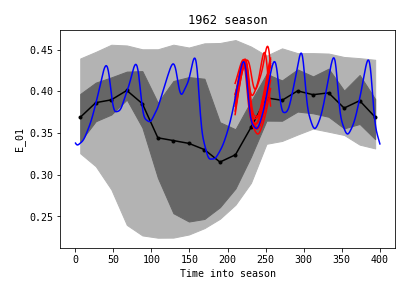

In [26]:
feat = "t_szn" # Horizontal axis: time of season
obs = "E_01" # Vertical axis: energy of the first Fourier mode. This can be anything from feat_tpt_list
sel = dict(ensemble=0, member=0)
fig,ax = plt.subplots()
tpt_utils.plot_field_1d(
    feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature=obs).data.flatten(),
    np.ones(feat_tpt["ra"]["t_sim"].size),
    feat_tpt["ra"]["X"].sel(sel).sel(feature=feat).data.flatten(),
    feat_name="Time into season", field_name=obs,
    fig=fig, ax=ax
)
# Now overlay a specific year of reanalysis
year2plot = 1962
sel = dict(ensemble=0, member=0)
cond = 1*(feat_tpt["ra"]["X"].sel(feature="szn_start_year") == year2plot)
ra_one_season = feat_tpt["ra"]["X"].where(cond,drop=True).sel(sel,drop=True)
ax.plot(
    ra_one_season.sel(feature=feat).data.flatten(),
    ra_one_season.sel(feature=obs).data.flatten(),
    color='blue', zorder=4
)
# Now overlay a specific hindcast ensemble from the same year
ensemble_number_in_season = 15 # Whichever number ensemble of the season we wish to see
cond = 1*(
    (feat_tpt["hc"]["X"].sel(feature="szn_start_year") == year2plot) 
)
hc_one_window = feat_tpt["hc"]["X"].where(cond,drop=True)
# Find the index of the first ensemble of that year
ensemble_time_order = np.argsort(hc_one_window.isel(t_sim=0).sel(member=0,feature="t_szn").data.flatten())
for i_mem in range(feat_tpt["hc"]["X"].coords["member"].size):
    ax.plot(
        hc_one_window.isel(ensemble=ensemble_time_order[ensemble_number_in_season]).sel(member=i_mem,feature=feat).data.flatten(),
        hc_one_window.isel(ensemble=ensemble_time_order[ensemble_number_in_season]).sel(member=i_mem,feature=obs).data.flatten(),
        color='red', zorder=3
    )
ax.set_title(f"{year2plot} season")


# Defining the event

By plotting the observable `x1` or `E_01` (proportional to the square of `x1`) above, we can see what a blocking event looks like: sometime between 100 and 250 days into the season, `x1` dips very low, with a variable magnitude and duration.  We make a straightforward definition for blocking with the following threshold:
1. `x1_thresh0`: the value that `x1` must drop below to reach state `B`
2. `x1_thresh1`: the value that `x1` must rise above to reach state `A`
3. `t_thresh0`: the beginning of the time interval (relative to the start of the season) during which we expect blocking. It must be positive.
4. `t_thresh1`: the ending of the time interval. It must be greater than `t_thresh0`, and less than `crom_feat.szn_length`. 

Below we specify one arbitrary set of thresholds, which could be adjusted. In particular, we could change `x1_thresh1` to resolve different levels of severity. We could also swap `x1` with `x1_runmean` to use some time-averaged criterion---*as long as it is computable from `feat_tpt`.* I've chosen `x1_thresh1` to be very high, so set `A` is never reached during the season: `A` is really the off-season. All this information gets stored in the `crom_feat` object, so we can later query data points by their membership in `A` or `B`. 


In [27]:
t_thresh0 = 10.0
t_thresh1 = 200.0
x1_thresh0 = 0.75
x1_thresh1 = 2.0 # 2.0 may as well be infinity
crom_feat.set_ab_boundaries(t_thresh0, t_thresh1, x1_thresh0, x1_thresh1)

# Empirical committors and hitting times

Now that we've specified how to tell whether a datapoint is in `A` or `B`, let's apply this function to all the reanalysis and hindcast data. We'll get a new `DataArray` called `ab_tag`, holding integers which code for `A`, `B`, or `D` (the complement of `A` and `B`). Furthermore, we will calculate hitting times, both in the future and past, for every data point. This information will be stored in `sintil` (combining "since" and "until", and computed from a function named `cotton_eye_joe`---look this up on YouTube). Once we have hitting times, the *empirical* committor is trivial to compute: it is one if the time to `B` is less than the time to `A`, and zero otherwise. In backward time, it is one if the time elapsed since hitting `A` is less than the time elapsed since hitting `B`.

In [28]:
compute_empirical_committor_flag = 1

In [29]:
reload(feature_template)
reload(feature_crommelin)

<module 'feature_crommelin' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/crommelin/feature_crommelin.py'>

In [30]:
crom_feat = feature_crommelin.SeasonalCrommelinModelFeatures()
crom_feat.set_event_seasonal_params(espd)
crom_feat.set_ab_boundaries(t_thresh0, t_thresh1, x1_thresh0, x1_thresh1)

In [31]:
if compute_empirical_committor_flag:
    ab_tag = dict()
    sintil = dict() # Hitting times (since and until)
    comm_emp = dict() # Empirical committor: to B in forward time, from A in backward time
    for src in ["ra","hc"]:
        ab_tag[src] = crom_feat.ab_test(feat_tpt[src]["X"])
        mode = "timechunks" if src == "ra" else "timesteps" # This determines the computation pattern for iterating through the dataset
        sintil[src] = crom_feat.cotton_eye_joe(feat_tpt[src]["X"],ab_tag[src],mode=mode)
        comm_emp[src] = 1*(sintil[src].sel(state="B") < sintil[src].sel(state="A"))
        comm_emp[src].loc[dict(sense="since")] = 1 - comm_emp[src].sel(sense="since")
        # Save each item
        ab_tag[src].to_netcdf(join(filedict["results"]["dir"], f"ab_tag_{src}.nc"))    
        sintil[src].to_netcdf(join(filedict["results"]["dir"], f"sintil_{src}.nc"))    
        comm_emp[src].to_netcdf(join(filedict["results"]["dir"], f"comm_emp_{src}.nc"))

t_sim.shape = (160000,)
Forward pass: through time 0 out of 94
Backward pass: through time 0 out of 94


Close and reload these files for use later on.

In [32]:
for src in ["ra","hc"]:
    ab_tag[src].close()
    sintil[src].close()
    comm_emp[src].close()

In [33]:
ab_tag = dict()
sintil = dict() # Hitting times (since and until)
comm = dict() # Committor: to B in forward time, from A in backward time
for src in ["ra","hc"]:
    ab_tag[src] = xr.open_dataarray(join(filedict["results"]["dir"], f"ab_tag_{src}.nc"))    
    sintil[src] = xr.open_dataarray(join(filedict["results"]["dir"], f"sintil_{src}.nc"))    
    comm[src] = xr.open_dataarray(join(filedict["results"]["dir"], f"comm_{src}.nc"))

Below we confirm visually that the detection algorithm above is working. Along with of a timeseries of `x(t)`, we highlight the time intervals during which the system is in `A` and `B` in blue and red respectively.

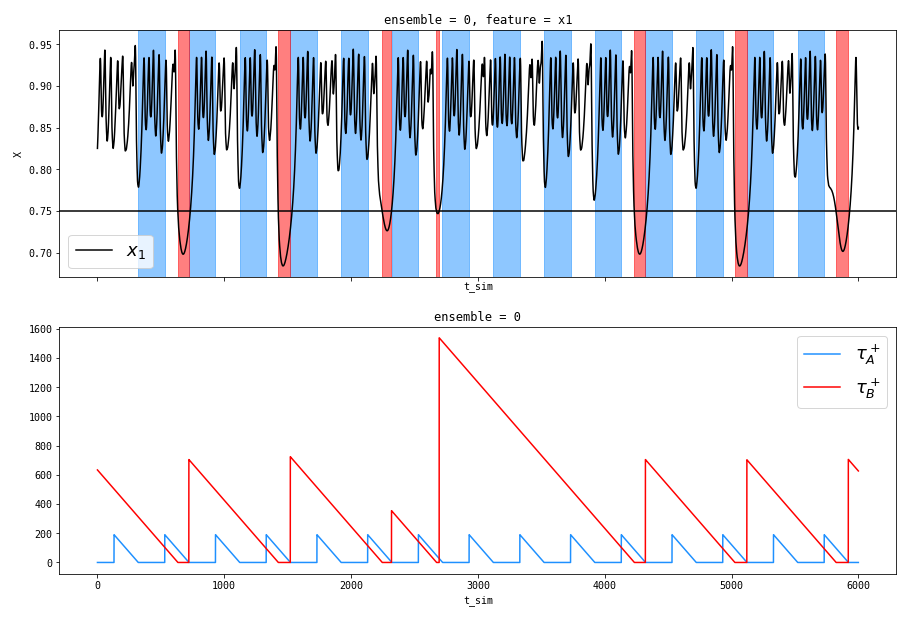

In [34]:
fig,axes = plt.subplots(nrows=2, figsize=(15,10), sharex=True)
sel = dict(member=0, t_sim=slice(None,6000))
h_x1, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="x1"),
    color="black",ax=axes[0],label="$x_1$",x="t_sim"
)
handles = []
for set_code in ["A","B"]:
    color = "dodgerblue" if set_code == "A" else "red"
    starts, = np.where(np.diff(1*(ab_tag["ra"].sel(sel,drop=True).data.flatten()==crom_feat.ab_code[set_code])) == 1)
    ends, = np.where(np.diff(1*(ab_tag["ra"].sel(sel,drop=True).data.flatten()==crom_feat.ab_code[set_code])) == -1)
    if starts[0] > ends[0]: 
        ends = ends[1:]
    if starts[-1] > ends[-1]:
        starts = starts[:-1]
    for i in range(len(starts)):
        axes[0].axvspan(
            feat_tpt["ra"]["t_sim"][starts[i]], feat_tpt["ra"]["t_sim"][ends[i]], 
            color=color, alpha=0.5, zorder=-1
        )
    h_hittime, = xr.plot.plot(
        sintil["ra"].sel(sel,drop=True).sel(state=set_code, sense="until", drop=True),
        ax=axes[1], label=r"$\tau_%s^+$"%(set_code), color=color)
    handles += [h_hittime]

axes[0].axhline(y=crom_feat.tpt_bndy["x1_thresh"][0], color='black')
axes[0].legend(handles=[h_x1], prop={"size": 18})
axes[1].legend(handles=handles, prop={"size": 18})


In [35]:
num_B_entries = np.sum(
    np.diff(
        (ab_tag["ra"].sel(member=0,ensemble=0)==crom_feat.ab_code["B"]).data.flatten()
    ) == 1
)

### Plot the empirical committor and lead time, from reanalysis

Now we have a bunch of *empirical* committors (a point cloud of ones and zeros) as well as lead times (a point cloud of positive real numbers). We can projecting this point cloud into lower dimensions (1 or 2) to get a picture of the committor or lead time as a function of those coordinates.

First, let's plot as a function of one variable, using `tpt_utils.plot_field_1d`. This shows the conditional mean as a black curve, the interquartile range as a dark gray envelope, and the min-max range as a light gray envelope.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='E_01', ylabel='Committor to B'>)

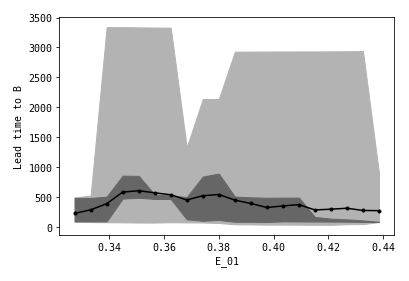

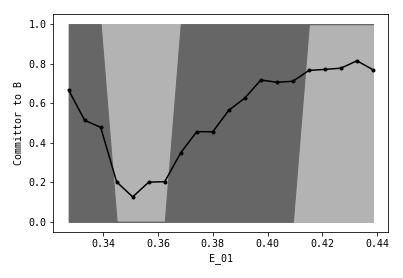

In [36]:
feat = "E_01" # The independent variable
sel = dict(ensemble=0,member=0)
cond = (
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") > crom_feat.tpt_bndy["t_thresh"][0]) * 
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") < crom_feat.tpt_bndy["t_thresh"][0]+10) 
)
tpt_utils.plot_field_1d(
    sintil["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten(), 
    np.ones(cond["t_sim"].size),
    feat_tpt["ra"]["X"].sel(sel).sel(feature=[feat]).where(cond).data.flatten(),
    ax=axes[0],
    feat_name=feat, field_name="Lead time to B",
)
tpt_utils.plot_field_1d(
    comm_emp["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten(), 
    np.ones(cond["t_sim"].size),
    feat_tpt["ra"]["X"].sel(sel).sel(feature=feat).where(cond).data.flatten(),
    ax=axes[1],
    feat_name=feat, field_name="Committor to B"
)

If we choose `E_01` as the feature, we see some interesting behavior: the committor has a minimum at a relatively small value of `E_01` and is maximum at large values---even though set `B` is defined by anomalously *low* values of `E_01`. Apparently, the zonal-mean energy value becomes abnormally large before collapsing.

We can also visualize these functions over two dimensions, using the function `tpt_utils.plot_field_2d`. We keep the horizontal axis the same feature, `E_01` (the energy of the mean flow), and additionally resolve a second observable: `Ex_11-12`, the exchange of energy between wavenumber `(1,1)` and wavenumber `(1,2)`. This reveals a little more what's happening, but there are many more coordinates to explore. 

We have also added a third panel. Besides the committor and mean-first-passage-time (`E[\tau_B^+]`), we're plotting the *lead time* `\eta_B^+`, which is the conditional expectation of `\tau_B^+` conditional on hitting `B` first. 

How do we do this from empirical data? Note that the first two arguments of `tpt_utils.plot_field_2d` (or `1D`) are the function values, and the weights for performing the marginal integration. For the committor and ordinary MFPT, the weights are uniform: we don't weight any datapoints more heavily than others. The conditional version only counts points that hit `B` first, so we multiply the function value by the committor, and ultimately we divide by the committor of that grid box in 2D. 

We've also selected a subset of the season, in order to see patterns more clearly (they will change over the course of the season). Slicing the data more finely gives more details, but reduces statistical confidence due to limited data. Try playing with the time subset and the features of interest. 

(<Figure size 1080x360 with 3 Axes>,
 <AxesSubplot:title={'center':'$-\\eta_B^+$'}, xlabel='E_01', ylabel='Ex_11-12'>)

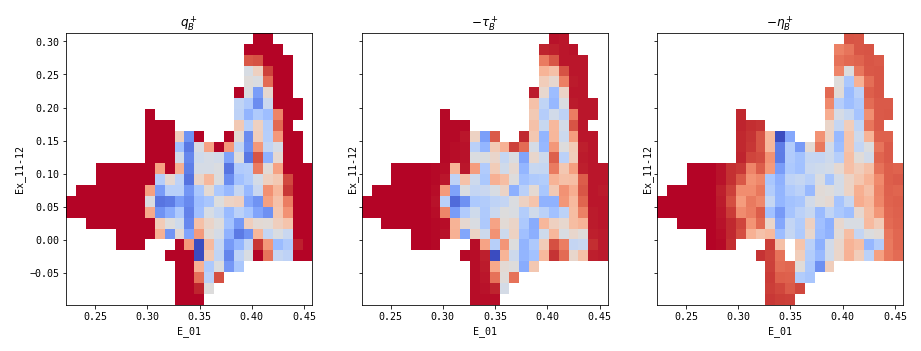

In [37]:
# Choose the two features
feat0,feat1 = "E_01","Ex_11-12"
# Select the first ensemble and member (trivial for reanalysis: there's only one realization)
sel = dict(ensemble=0,member=0) 
# Take a slice of the season, between two times
cond = (
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") > crom_feat.tpt_bndy["t_thresh"][0]) * 
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") < crom_feat.tpt_bndy["t_thresh"][0] + 100) 
)
# Call the committor qp (q-plus) and the hitting time to B Tb
qp = comm_emp["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten()
Tb = sintil["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten()

fig,axes = plt.subplots(ncols=3,figsize=(15,5), sharey=True, sharex=True)
# First plot: committor
tpt_utils.plot_field_2d(
    qp, # function values
    np.ones(feat_tpt["ra"]["t_sim"].size), # weights
    feat_tpt["ra"]["X"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True), # Feature space
    feat_names = [feat0,feat1],  # axis labels
    shp=[25,25], # shape of the 2D grid controls how pixellated the image is
    fig=fig, ax=axes[0], field_name=r"$q_B^+$" #other display parameters
)
# Second plot: hitting time (negative, so it increases towards B)
tpt_utils.plot_field_2d(
    -Tb,
    np.ones(feat_tpt["ra"]["t_sim"].size),
    feat_tpt["ra"]["X"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[25,25], fig=fig, ax=axes[1], field_name=r"$-\tau_B^+$"
)
# Third plot: hitting time conditioned on hitting B first
tpt_utils.plot_field_2d(
    -Tb*qp,
    qp,
    feat_tpt["ra"]["X"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[25,25], fig=fig, ax=axes[2], field_name=r"$-\eta_B^+$"
)


Finally, we should estimate the rate. What fraction of seasons involve a blocking event?

In [38]:
num_B_entries = np.sum(
    np.diff(
        1*(ab_tag["ra"].sel(member=0,ensemble=0)==crom_feat.ab_code["B"]).data.flatten()
    ) == 1
)
num_seasons = (
    feat_tpt["ra"]["X"].sel(feature="szn_start_year").isel(t_sim=-1).data.flatten() - 
    feat_tpt["ra"]["X"].sel(feature="szn_start_year").isel(t_sim=0).data.flatten()
).data[0]


In [39]:
print(f"There were {num_B_entries} blocking onsets in {num_seasons} seasons, for an overall rate of {num_B_entries/num_seasons}")

There were 90 blocking onsets in 200.0 seasons, for an overall rate of 0.45


# Markov State Modeling using hindcasts

We now wish to find the committor and lead time using hindcasts. Since the hindcast trajectories don't last all winter, we have to chain them together using a Markov State Model (MSM). The steps to building a MSM are:
1. Select a set of features
2. Cluster the data *separately at each time of the season*
3. Count transitions from each box in time window `k` to each box in time window `k+1`, building a set of transition probability matrices

### 1. Select a set of features
Below we hand-pick some features that we think will be effective inputs to a clustering algorithm. I've chosen the basic state space coordinates of the model, since I know this ahead of time. Of course, for a more complicated model we cannot do this. It's an interesting question which features comprise "sufficient statistics" for the rate and other TPT quantities. 

In [74]:
#msm_features = ["E_01","E_02","E_11","E_12","Ex_11-diss","Ex_11-02","Ex_11-12","Edot_forcing"] 
msm_features = ["x1","x2","x3","x4","x5","x6"]
feat_msm = dict()
for src in ["ra","hc"]:
    feat_msm[src] = feat_tpt[src]["X"].sel(feature=msm_features)

Especially in applications, the different features may have different units and different characteristic scales. For clustering to be effective, the dataset should be homogeneously shaped. Therefore, we need to center and normalize each feature according to its statistics during each time window of the season.

The all-useful function `tpt_utils.project_field` can give us seasonal statistics easily (it is also used in `plot_field_<1,2>d` above). Below we compute statistics for every time window, including the mean and standard deviation, and store it in a `DataArray` called `szn_stats`. 

In [75]:
# Compute seasonal statistics
szn_stats_dict,edges,centers = tpt_utils.project_field(
    feat_msm["ra"].sel(ensemble=0,member=0).data, 
    np.ones_like(feat_msm["ra"].sel(ensemble=0,member=0).data),
    feat_tpt["ra"]["X"].sel(feature="t_szn",ensemble=0,member=0).data.reshape(-1,1),
    bounds = np.array([0.0, crom_feat.year_length+0.0001]).reshape(-1,1),
    shp = (int(crom_feat.year_length/crom_feat.dt_szn + 0.5),)
)
szn_stats = xr.Dataset(
    data_vars = dict({
        key: xr.DataArray(
            coords={"t_szn_cent": centers[0], "feature": msm_features,},
            data=szn_stats_dict[key],
            dims=["t_szn_cent", "feature"],
        ) 
        for key in list(szn_stats_dict.keys())
    }),
    attrs = {
        "t_szn_edge": edges[0], "t_szn_cent": centers[0], 
        "dt_szn": edges[0][1]-edges[0][0], "Nt_szn": len(centers[0]),
        "szn_start": crom_feat.szn_start, "szn_length": crom_feat.szn_length
    }
)

Now we normalize the features to use in the MSM by their mean and standard deviation. Also, in order to ensure non-degenerate transition matrices, we exclude any trajectories whose starting point or ending point lies in the given time window `i_win`. 

In [76]:
feat_msm_normalized = dict()
szn_window = dict()
szn_start_year = dict()
traj_beginning_flag = dict() # 1 if the sample is in the first seasonal time window where the trajectory started
traj_ending_flag = dict() # 1 if the sample is in the last seasonal time window occupied by the trajectory
for src in ["ra","hc"]:
    feat_msm_normalized[src] = feat_msm[src].copy(deep=True)
    szn_window[src] = feat_tpt[src]["X"].sel(feature="ti_szn").astype(int) #/szn_stats.attrs["dt_szn"]).astype(int)
    szn_start_year[src] = feat_tpt[src]["X"].sel(feature="szn_start_year").astype(int)
    for i_win in range(szn_stats.attrs["Nt_szn"]):
        feat_msm_normalized[src] = xr.where(
            szn_window[src]==i_win, 
            (feat_msm_normalized[src] - szn_stats["mean"].isel(t_szn_cent=i_win,drop=True)) / szn_stats["std"].isel(t_szn_cent=i_win,drop=True), 
            feat_msm_normalized[src]
        )
    # --------------- Mark the trajectories that originated in an earlier time window and will reach another time window ---------------
    traj_ending_flag[src] = (
        (szn_window[src] == szn_window[src].isel(t_sim=-1,drop=True))*
        (szn_start_year[src] == szn_start_year[src].isel(t_sim=-1,drop=True))
    )
    traj_beginning_flag[src] = (
        (szn_window[src] == szn_window[src].isel(t_sim=0,drop=True))*
        (szn_start_year[src] == szn_start_year[src].isel(t_sim=0,drop=True))
    )
    # -----------------------------------------------------------------------------------------------

Now let's cluster into boxes at each timestep. Note, this could be parallelized. 

In [77]:
km_seed = 43 # for the random number generator

km_assignment = dict()
km_centers = dict()
km_n_clusters = dict()
for src in ["hc","ra"]:
    km_assignment_src = -np.ones((feat_tpt[src]["ensemble"].size,feat_tpt[src]["member"].size,feat_tpt[src]["t_sim"].size), dtype=int)
    km_centers[src] = []
    km_n_clusters[src] = -np.ones(szn_stats.attrs["Nt_szn"], dtype=int)

    for i_win in range(szn_stats.attrs["Nt_szn"]):
        if i_win % 10 == 0:
            print(f"Starting K-means number {i_win} out of {szn_stats.attrs['Nt_szn']}")
        idx_in_window = np.where(szn_window[src].data==i_win) # All the data in this time window
        # idx_for_clustering is all the data that we're allowed to use to build the KMeans object
        if i_win == 0:
            idx_for_clustering = np.where(
                (szn_window[src].data==i_win)*
                (traj_ending_flag[src].data == 0)
            )
        elif i_win == szn_stats.attrs["Nt_szn"]-1:
            idx_for_clustering = np.where(
                (szn_window[src].data==i_win)*
                (traj_beginning_flag[src].data == 0)
            )            
        else:
            idx_for_clustering = np.where(
                (szn_window[src].data==i_win)*
                (traj_ending_flag[src].data == 0)*
                (traj_beginning_flag[src].data == 0)
            )
        km_n_clusters[src][i_win] = min(200,max(1,len(idx_for_clustering[0]//2)))
        km = KMeans(n_clusters=km_n_clusters[src][i_win],random_state=km_seed).fit(
                feat_msm_normalized[src].data[idx_for_clustering])
        km_assignment_src[idx_in_window] = km.predict(feat_msm_normalized[src].data[idx_in_window]) 
        km_centers[src] += [km.cluster_centers_]
        #print(f"\tkm_centers computation: {t5 - t4}")
    km_assignment[src] = xr.DataArray(
        coords={"ensemble": feat_tpt[src]["ensemble"], "member": feat_tpt[src]["member"], "t_sim": feat_tpt[src]["t_sim"]},
        dims=["ensemble","member","t_sim"],
        data=km_assignment_src.copy()    #np.zeros((feat_tpt[src]["ensemble"].size,feat_tpt[src]["member"].size,feat_tpt[src]["t_sim"].size), dtype=int)
    )    



Starting K-means number 0 out of 80
Starting K-means number 10 out of 80
Starting K-means number 20 out of 80
Starting K-means number 30 out of 80
Starting K-means number 40 out of 80
Starting K-means number 50 out of 80
Starting K-means number 60 out of 80
Starting K-means number 70 out of 80
Starting K-means number 0 out of 80
Starting K-means number 10 out of 80
Starting K-means number 20 out of 80
Starting K-means number 30 out of 80
Starting K-means number 40 out of 80
Starting K-means number 50 out of 80
Starting K-means number 60 out of 80
Starting K-means number 70 out of 80


Now build the Markov State Model by counting transitions from box to box. This part could also be parallelized.

In [78]:
P_list = dict()
for src in ["hc","ra"]:
    time_dim = list(szn_window[src].dims).index("t_sim")
    nontime_dims = np.setdiff1d(np.arange(len(szn_window[src].dims)), [time_dim])
    P_list[src] = []
    for i_win in range(szn_stats.attrs["Nt_szn"]-1):
        if i_win % 10 == 0: print(f"i_win = {i_win}")
        P = np.zeros((km_n_clusters[src][i_win],km_n_clusters[src][i_win+1]))
        # Count the trajectories that passed through both box i during window i_win, and box j during window i_win+1. 
        # Maybe some trajectories will be double counted. 
        idx_pre = np.where(szn_window[src].data==i_win)
        idx_post = np.where(szn_window[src].data==i_win+1)
        overlap = np.where(
            np.all(
                np.array([
                    (np.subtract.outer(idx_pre[dim], idx_post[dim]) == 0) 
                    for dim in nontime_dims
                ]), axis=0
            ) * (
                np.subtract.outer(
                    szn_start_year[src].data[idx_pre], szn_start_year[src].data[idx_post]
                ) == 0
            )          
        )
        idx_pre_overlap = tuple([idx_pre[dim][overlap[0]] for dim in range(len(idx_pre))])
        idx_post_overlap = tuple([idx_post[dim][overlap[1]] for dim in range(len(idx_pre))])
        km_pre = km_assignment[src].data[idx_pre_overlap]
        km_post = km_assignment[src].data[idx_post_overlap]
        ensemble_member_year_identifier = np.concatenate((
            np.array(idx_pre_overlap)[nontime_dims,:], 
            [szn_start_year[src].data[idx_pre_overlap]]
        ), axis=0)
        for i in range(P.shape[0]):
            for j in range(P.shape[1]):
                traj_idx, = np.where((km_pre==i)*(km_post==j))
                P[i,j] = np.unique(ensemble_member_year_identifier[:,traj_idx], axis=1).shape[1]
        min_rowsum = np.min(np.sum(P, axis=1))
        min_colsum = np.min(np.sum(P, axis=0))
        if min_rowsum == 0 or min_colsum == 0:
            raise Exception(f"Under-filled transition matrices between seasonal windows {i_win} and {i_win+1}. min_rowsum = {min_rowsum} and min_colsum = {min_colsum}")
        P_list[src] += [P]


i_win = 0
i_win = 10
i_win = 20
i_win = 30
i_win = 40
i_win = 50
i_win = 60
i_win = 70
i_win = 0
i_win = 10
i_win = 20
i_win = 30
i_win = 40
i_win = 50
i_win = 60
i_win = 70


In [79]:
# Normalize each matrix
for src in ["hc","ra"]:
    for i_win in range(szn_stats.attrs["Nt_szn"]-1):
        P_list[src][i_win] = (
            np.diag(1.0/np.sum(P_list[src][i_win], axis=1))
            .dot(P_list[src][i_win])
        )

In [80]:
# Save out the data relevant for clustering
msm_info = dict()
for src in ["hc","ra"]:
    msm_info[src] = dict({
        "szn_window": szn_window[src],
        "szn_start_year": szn_start_year[src],
        "traj_beginning_flag": traj_beginning_flag[src],
        "traj_ending_flag": traj_ending_flag[src],
        "km_centers": km_centers[src],
        "km_assignment": km_assignment[src],
        "km_n_clusters": km_n_clusters[src],
        "P_list": P_list[src],
    })
pickle.dump(msm_info, open(join(filedict["results"]["dir"], "msm_info"), "wb"))

In [81]:
msm_info = pickle.load(open(join(filedict["results"]["dir"], "msm_info"), "rb"))

In [82]:
# Make a function to assign every point in the dataset a value according to its K-means assignment
def broadcast_field_msm2dataarray(msm, field_msm, szn_stats, density_flag=False):
    field_da = np.zeros(msm["szn_window"].shape)
    for i_win in range(szn_stats.attrs["Nt_szn"]):
        idx_in_window = np.where(msm["szn_window"].data == i_win)
        for i_clust in range(msm["km_n_clusters"][i_win]):
            idx_in_cluster = np.where(msm["km_assignment"].data[idx_in_window] == i_clust)
            idx_in_window_and_cluster = tuple([idx_in_window[dim][idx_in_cluster] for dim in range(len(idx_in_window))])
            field_da[idx_in_window_and_cluster] = field_msm[i_win][i_clust]
            if density_flag and (len(idx_in_window_and_cluster[0]) > 0):
                field_da[idx_in_window_and_cluster] *= 1.0/len(idx_in_window_and_cluster[0])
    da_broadcast = xr.DataArray(
        coords = msm["szn_window"].coords,
        dims = msm["szn_window"].dims, 
        data = field_da,
    )
    return da_broadcast


# Solve for the committor

First assign flags to each cluster center for A or B membership. For this we need to refer to the original data in the membership list of each cluster.

In [83]:
# Create a list of vectors to flag whether each cluster at each time is in A or is in B
src = "hc"
ina = []
inb = []
for i_win in range(szn_stats.attrs["Nt_szn"]):
    ina += [np.zeros(km_n_clusters[src][i_win], dtype=float)]    
    inb += [np.zeros(km_n_clusters[src][i_win], dtype=float)]
    idx_in_window = np.where(szn_window[src].data==i_win)
    ab_tag_in_window = ab_tag[src].data[idx_in_window]
    for i_clust in range(km_n_clusters[src][i_win]):
        idx_in_cluster = np.where(km_assignment[src].data[idx_in_window]==i_clust)
        ina[i_win][i_clust] = 1.0*(np.mean(ab_tag_in_window[idx_in_cluster]==crom_feat.ab_code["A"]) == 1.0)
        inb[i_win][i_clust] = 1.0*(np.mean(ab_tag_in_window[idx_in_cluster]==crom_feat.ab_code["B"]) == 1.0)

In [84]:
sum(np.concatenate(inb)) # Count how many clusters actually got classified as in B

351.0

Finally, we can estimate the rate according to TPT. This will use some simple functions from `tdmc_obj.py`, which implements a class definition for a "time-dependent Markov chain". 

In [85]:
# Instantiate the time-dependent Markov Chain class
import tdmc_obj
mc = tdmc_obj.TimeDependentMarkovChain(msm_info[src]["P_list"], szn_stats.attrs["t_szn_cent"])

# Solve for the committor
G = [] 
F = [] 
for i in range(mc.Nt):
    G += [1.0*inb[i]]
    if i < mc.Nt-1: F += [1.0*np.outer((ina[i]==0)*(inb[i]==0), np.ones(mc.Nx[i+1]))]
qp = mc.dynamical_galerkin_approximation(F,G)

# Solve for the time-dependent density
init_dens = np.ones(msm_info["hc"]["km_n_clusters"][0]) 
init_dens *= 1.0/np.sum(init_dens)
dens = mc.propagate_density_forward(init_dens)

# Solve for the backward committor
P_list_bwd = []                                                        
for i in np.arange(mc.Nt-2,-1,-1):
    P_list_bwd += [(msm_info["hc"]["P_list"][i] * np.outer(dens[i], 1.0/dens[i+1])).T]        
    rowsums = np.sum(P_list_bwd[-1],axis=1)                    
G = []
F = []
for i in np.arange(mc.Nt-1,-1,-1):                             
    G += [1.0*ina[i]]                                          
    if i < mc.Nt-1: 
        Fnew = np.outer(1.0*(ina[i+1]==0)*(inb[i+1]==0), np.ones(len(inb[i]))) 
        F += [Fnew.copy()]
qm = mc.dynamical_galerkin_approximation(F,G)                  
qm.reverse()

# Solve for the rate
flux = []
rate_froma = 0
rate_tob = 0
flux_froma = []
flux_tob = []
flux_dens_tob = np.zeros(szn_stats.attrs["Nt_szn"])
for ti in range(szn_stats.attrs["Nt_szn"]-1):
    flux += [(msm_info["hc"]["P_list"][ti].T * dens[ti] * qm[ti]).T * qp[ti+1]]
    flux_froma += [(msm_info["hc"]["P_list"][ti].T * dens[ti] * ina[ti]).T * qp[ti+1]]
    flux_tob += [(msm_info["hc"]["P_list"][ti].T * dens[ti] * qm[ti]).T * inb[ti+1]]
    rate_froma += np.sum(flux_froma[-1])
    rate_tob += np.sum(flux_tob[-1])
    flux_dens_tob[ti] = np.sum(flux_tob[-1])

Ideally, the rate should be the same by both estimates `rate_froma` and `rate_tob`. Are they really?

In [86]:
print(f"rate_tob = {rate_tob}")
print(f"rate_froma = {rate_froma}")

rate_tob = 0.4098233549020127
rate_froma = 0.4390668375393554


Not quite. We'll have to think about this. it really should be exact, for this Markov Chain approximation. However, both are decent estimates for the empirical rate according to reanalysis. 

## Visualize MSM-derived committors

In [87]:
qp_da = broadcast_field_msm2dataarray(msm_info[src], qp, szn_stats)
pi_da = broadcast_field_msm2dataarray(msm_info[src], dens, szn_stats, density_flag=True)
qm_da = broadcast_field_msm2dataarray(msm_info[src], qm, szn_stats)

(<Figure size 1080x360 with 3 Axes>,
 <AxesSubplot:title={'center':'$q_A^-$'}, xlabel='E_01', ylabel='Ex_11-12'>)

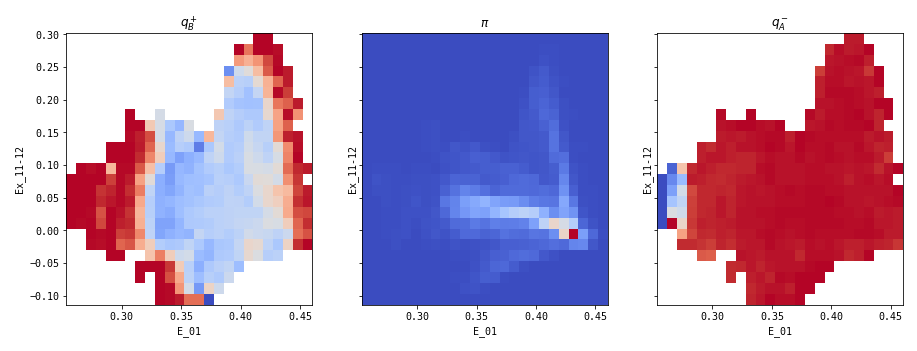

In [88]:
fig,axes = plt.subplots(ncols=3,figsize=(15,5),sharey=True)
cond = (
    (feat_tpt["hc"]["X"].sel(feature="t_szn",drop=True) > crom_feat.tpt_bndy["t_thresh"][0]) * 
    (feat_tpt["hc"]["X"].sel(feature="t_szn",drop=True) < crom_feat.tpt_bndy["t_thresh"][0] + 100) 
)
feat0,feat1 = "E_01","Ex_11-12"
features = np.array([feat_tpt["hc"]["X"].sel(feature=ft).where(cond).data.flatten() for ft in [feat0,feat1]]).T
weights = np.ones(features.shape[0])
tpt_utils.plot_field_2d(
    qp_da.where(cond).data.flatten(),
    weights,
    features,
    feat_names = [feat0,feat1], 
    shp=[25,25], fig=fig, ax=axes[0], field_name=r"$q_B^+$"
)
tpt_utils.plot_field_2d(
    pi_da.where(cond).data.flatten(),
    weights,
    features,
    feat_names = [feat0,feat1], 
    shp=[25,25], fig=fig, ax=axes[1], field_name=r"$\pi$",
    stat_name="sum"
)
tpt_utils.plot_field_2d(
    qm_da.where(cond).data.flatten(),
    weights,
    features,
    feat_names = [feat0,feat1], 
    shp=[25,25], fig=fig, ax=axes[2], field_name=r"$q_A^-$"
)

The committor doesn't look so bad. compared to the reanalysis picture. Try putting `t_szn` on the horizontal axis instead of `E_01` to see how this depends on time.

Coming soon: reactive current.